In [2]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional sklearn functions
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
#import seaborn as sns
from sklearn import metrics
import warnings
#Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
rcParams['figure.figsize'] = 12, 4
plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

data = pd.read_csv('/home/shxie/aiddsummary/AchE/paper_figure/final_full_dataset_goldi_like_for_models_new.csv')
target = 'Label'
IDcol = 'PDB'

In [4]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    """
    Defines a function to fit model.
    
    If useTrainCV is set to True, the function uses the training data to carry out 10 fold cross-validation
    by reserving 10% of the training set for as a validation/dev set. These XGBoost internal cross validation optimizes 
    the number of estimator by optimizing roc_auc on the classification task.
    The optimum number of estimator is then used to train the entire training set; the resulting model is then evaluated 
    on an independent test set.
    
    """
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,seed=27)
        print (cvresult.iloc[[0, -1]])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Label'], dtrain_predprob))
    print ("Accuracy(Test) : %.4g" % metrics.accuracy_score(dtest['Label'].values, dtest_predictions))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(dtest['Label'], dtest_predprob))
    feat_imp = pd.Series(alg.feature_importances_,index = alg.feature_names_in_).sort_values(ascending=False)               
    #feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #feat_imp1 = pd.Series(alg.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')#figsize=(10,10))
    #feat_imp1.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return (dtrain_predictions,dtest_predictions,dtrain_predprob,dtest_predprob)

In [5]:
def stratify_train_test(df, stratifyby, *args, **kwargs):
    train, test = pd.DataFrame(), pd.DataFrame()
    gb = df.groupby(stratifyby)
    for k in gb.groups:
        traink, testk = train_test_split(gb.get_group(k), *args, **kwargs)
        train = pd.concat([train, traink])
        test = pd.concat([test, testk])
    return train, test


train, test = stratify_train_test(data, 'Label', test_size=.1,random_state=27)

print (len(train[(train['Label']==1)]))
print (len(train))
print (len(test[(test['Label']==1)]))
print (len(test))

1244
4943
139
550


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.892181       0.009601       0.835342      0.014786
99        1.000000       0.000000       0.940526      0.015613

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9036
AUC Score (Test): 0.938823
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.892181       0.009601       0.835342      0.014786
99        1.000000       0.000000       0.940526      0.015613

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9036
AUC Score (Test): 0.938823


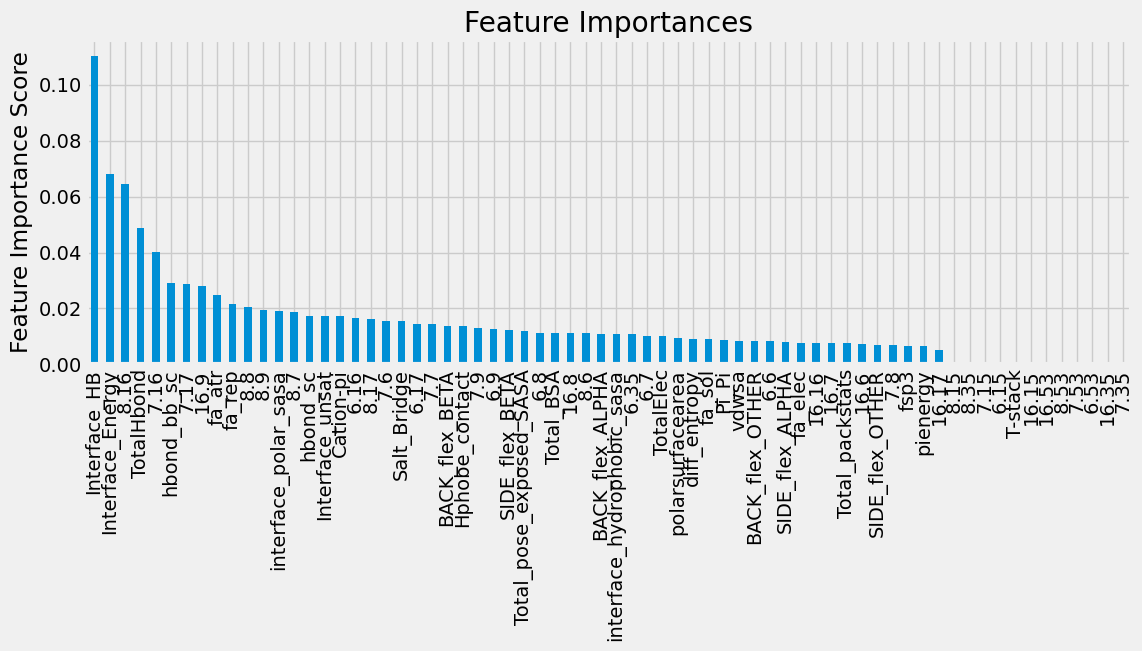

In [6]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb0 = XGBClassifier()
pred0 =modelfit(xgb0, train,test, predictors)

predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(seed=27)
pred1 =modelfit(xgb1, train,test, predictors)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.857312       0.005668       0.819059      0.015621
635        1.000000       0.000000       0.945471      0.013744

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9091
AUC Score (Test): 0.941343


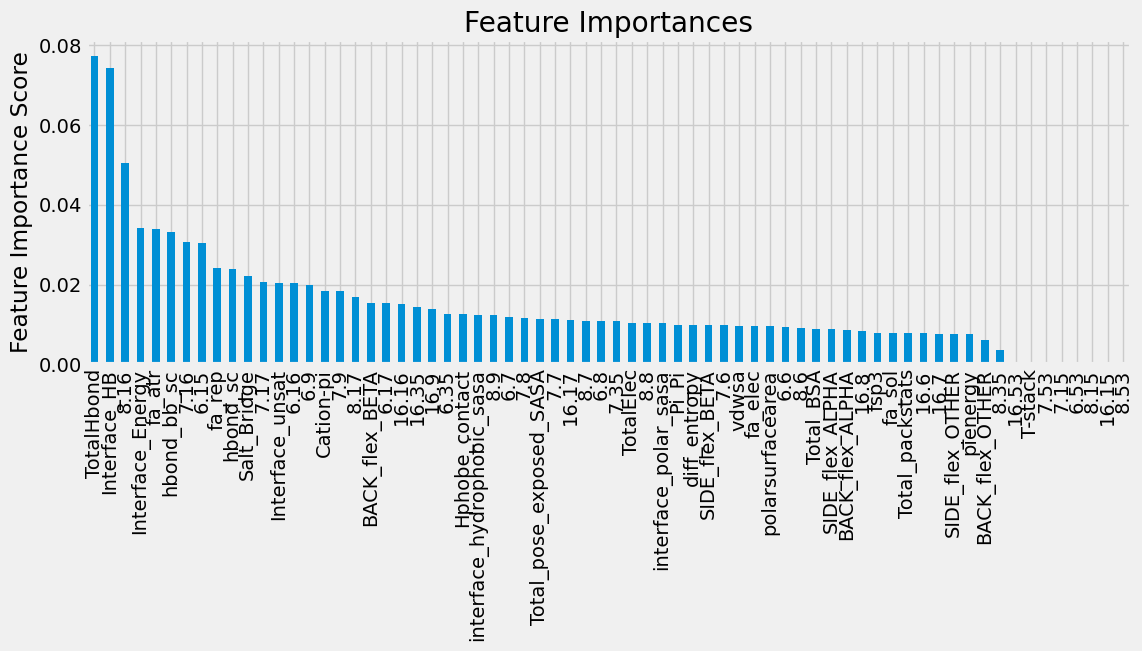

In [29]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)
pred1 =modelfit(xgb1, train,test, predictors)

In [33]:
#optimize the parameter by gridsearch
param_test2 = {
 'max_depth':range(1,10,1),
 'min_child_weight':range(1,10,1)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=368, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,cv=10)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_child_weight': 2}, 0.9453151313075466)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.888635       0.004088       0.823678      0.016189
243        1.000000       0.000000       0.943593      0.014767

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9073
AUC Score (Test): 0.941711


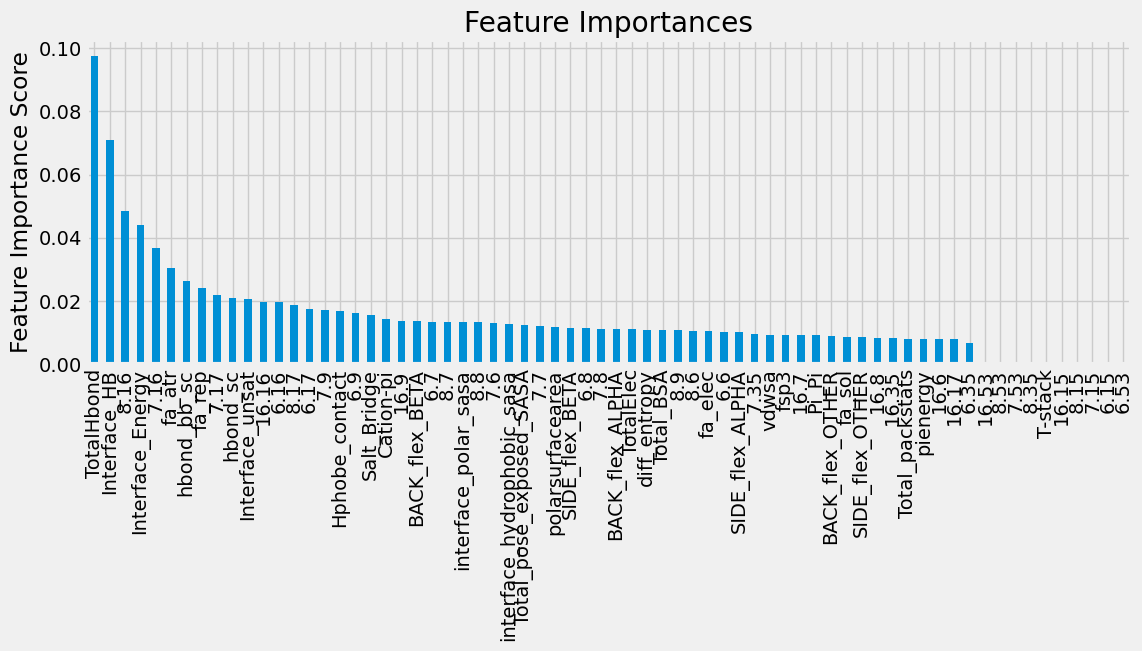

In [38]:
pred2 = modelfit(gsearch2.best_estimator_, train,test,predictors)

In [39]:
param_test4 = {
 'gamma':[i/10.0 for i in range(1,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=367, max_depth=7,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=10)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

({'gamma': 0.2}, 0.9439482110749617)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.888532       0.004122       0.823883      0.016477
403        1.000000       0.000000       0.944620      0.013180

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9127
AUC Score (Test): 0.943094


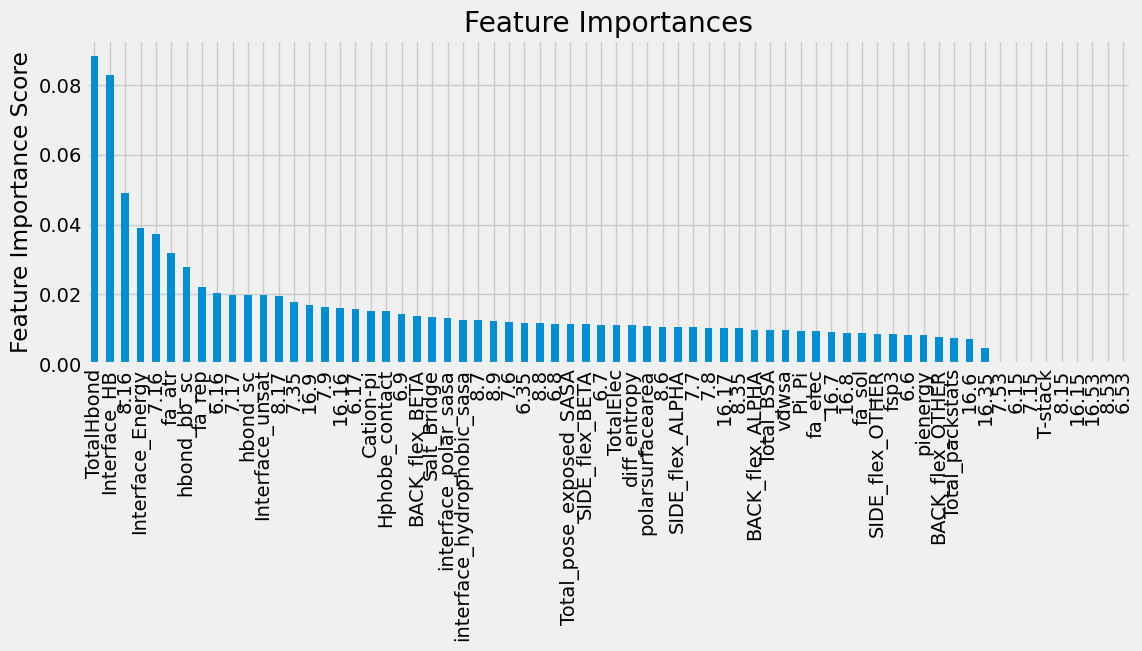

In [40]:
#recalibrating number of trees
"""
fitting a new model with the best parameter and recalibrating the best n_estimators so far.

Summary of result:
The new best n_estimators 
"""
xgb5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=2,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
pred5=modelfit(xgb5,train,test,predictors)

In [8]:
param_test5 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(1,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=667, max_depth=7,
 min_child_weight=2, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,cv=10)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9441828219722476)

In [9]:
param_test6 = {
 'reg_alpha':[0,1e-8,1e-7,1e-6 ]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=667, max_depth=7,
 min_child_weight=2, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=10)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0}, 0.9441828219722476)

      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.888532   4.122152e-03       0.823883      0.016477
1590        1.000000   8.058148e-08       0.944700      0.014410

Model Report
Accuracy : 0.9994
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9109
AUC Score (Test): 0.939663


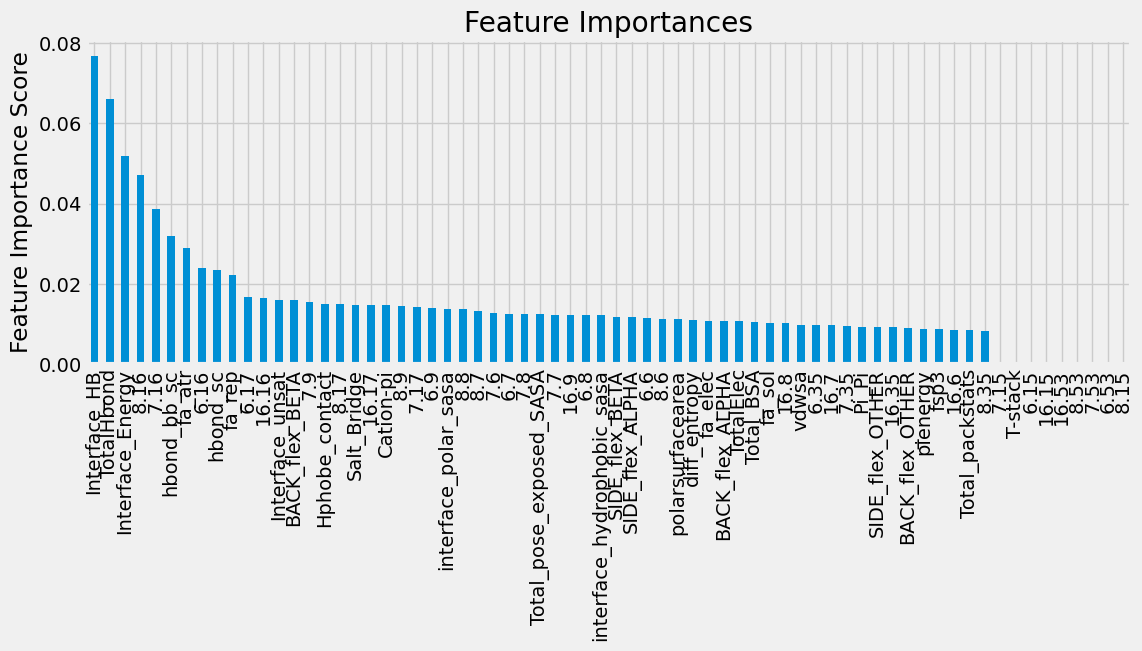

In [12]:
"""
Recalibrating the number of trees with all the optimized hyperparameter and saving the model. This is vScreenML model.
"""
import pickle
xgb7 = XGBClassifier(
learning_rate =0.01,
n_estimators=7000,
max_depth=7,
min_child_weight=2,
gamma=0.2,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
reg_alpha=0,
scale_pos_weight=1,
seed=27)
pred7=modelfit(xgb7, train,test, predictors)
model = xgb7.fit(train[predictors], train[target],eval_metric='auc')
# save model to file
with open("reproduced_xgb_mygridsearch.pickle.dat", 'wb') as f:
    pickle.dump(model, f)

      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.832825   1.036891e-02       0.779952      0.031652
1638        0.999999   5.199795e-07       0.945749      0.013310

Model Report
Accuracy : 0.9992
AUC Score (Train): 0.999998
Accuracy(Test) : 0.9145
AUC Score (Test): 0.940241


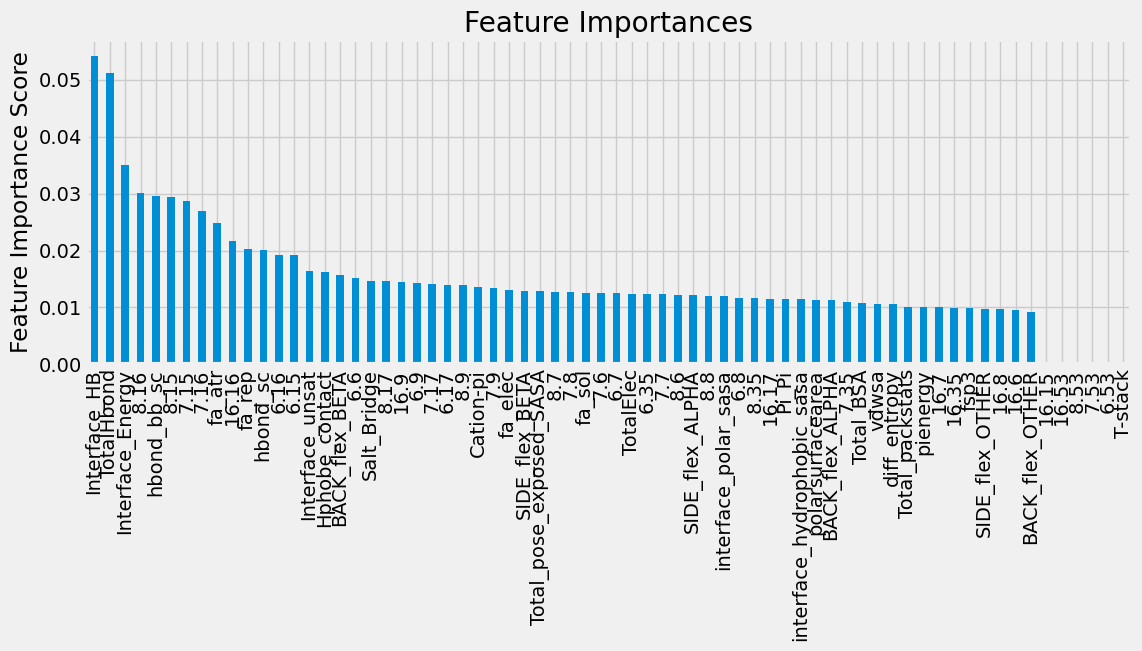

In [13]:
"""
Recalibrating the number of trees with all the optimized hyperparameter and saving the model. This is vScreenML model.
"""
import pickle
xgb7 = XGBClassifier(
learning_rate =0.01,
n_estimators=7000,
max_depth=7,
min_child_weight=1,
gamma=0.1,
subsample=0.5,
colsample_bytree=0.4,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27)
pred7=modelfit(xgb7, train,test, predictors)
model = xgb7.fit(train[predictors], train[target],eval_metric='auc')
# save model to file
with open("XGB_directly_reproduce.pickle.dat", 'wb') as f:
    pickle.dump(model, f)

In [14]:
with open('/home/shxie/aiddsummary/AchE/model/XGB_CLASSIFIER_alldata.pickle.dat', 'rb') as fr:
    model_origin = pickle.load(fr)
feat_imp = pd.Series(model_origin.feature_importances_,index = model_origin.feature_names_in_).sort_values(ascending=False)               
#feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
#feat_imp1 = pd.Series(alg.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')#figsize=(10,10))
#feat_imp1.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

ModuleNotFoundError: No module named 'sklearn.preprocessing.label'